In [1]:
import datasets
import matplotlib as plt
import tokenize
import transformers
from typing import Union
import numpy as np
import json
import evaluate

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the data from the policyqa folder
dataset = datasets.load_dataset('json', data_files={'train': 'LongPolicyQA/train.json', 'dev': 'LongPolicyQA/dev.json', 'test': 'LongPolicyQA/test.json'}, field='data') 


Using custom data configuration default-913cdbee94de1fe4
Reusing dataset json (/home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 3/3 [00:00<00:00, 175.64it/s]


In [3]:
# print the keys of the training dataset
print(dataset['test'][0]['paragraphs'][0:1][0])
print(dataset['test'][0].keys())

{'context': 'Last Updated on May 22, 2015', 'index': 1, 'qas': [{'answers': [{'answer_start': 0, 'text': 'Last Updated on May 22, 2015'}], 'id': '3f23wv3kh9cmvjio', 'question': "Do you take the user's opinion before or after making changes in policy?", 'type': 'Policy Change|||User Choice|||None'}, {'answers': [{'answer_start': 0, 'text': 'Last Updated on May 22, 2015'}], 'id': '5mk7ry5up95qrw7v', 'question': 'How do you inform all the users upon policy changes?', 'type': 'Policy Change|||Notification Type|||General notice in privacy policy'}], 'summary': ['The text does not fit into our label scheme.', 'The text introduces the policy, a section, or a group of practices, but it does not mention a specific practice.', 'When a change of an unspecified nature is made to the privacy policy, the policy date is updated or information about the change is posted as part of the policy. Users have no options regarding the change.']}
dict_keys(['title', 'paragraphs'])


In [4]:

def make_dataset_use_entire_document_as_context(row):
    """
    Convert the paragraphs into documents by:
    1. Iteratre over each paragraph in the document (supplied row)
    2. Concatenate all of the paragraphs' contexts together to form a single document
    3. Update the 'context' field of each paragraph to be the document
    4. Update the start of each answer to be the start of the answer in the document
    :param row: a row from the dataset representing a single document
    :return: the updated dataset.
    """
    
    # join all of the contexts together to form a single document, separating each with a newline
    entire_document = '\n'.join([paragraph['context'] for paragraph in row['paragraphs']])

    # the offset relative to the start of the document
    context_offset = 0 

    for paragraph in row['paragraphs']:
        original_context = paragraph['context']
        paragraph['context'] = entire_document
        for qa in paragraph['qas']:
            for answer in qa['answers']:
                answer['answer_start'] += context_offset

        # update the context offset for the next paragraph
        context_offset += len(original_context) + 1 # +1 for the newline character

    return row


def check_answer_offsets(row):
    """
    Check that the answer offsets are correct
    :param row: a row from the dataset representing a single document
    :return: Nothing
    """
    for paragraph in row['paragraphs']:
        for qa in paragraph['qas']:
            for answer in qa['answers']:
                start = answer['answer_start']
                selected_from_context = paragraph['context'][start:start + len(answer['text'])]
                actual_text = answer['text']
                assert selected_from_context == actual_text, f"Expected {actual_text} but got {selected_from_context}"

In [5]:
long_dataset = dataset.map(make_dataset_use_entire_document_as_context)

long_dataset.map(check_answer_offsets)

print(long_dataset['test'][0]['paragraphs'][0:1][0])

Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-78c9fc9a0ff30008.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-2957dba8bd06dba4.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-714761196846a39b.arrow
100%|██████████| 20/20 [00:00<00:00, 59.25ex/s]

{'context': 'Last Updated on May 22, 2015\nNew Orleans Tourism Marketing Corporation ("NOTMC" or "We") has created this privacy policy ("Privacy Policy") to explain our personal information collection practices and your options regarding such data. The Privacy Policy applies to your access and use of the NOTMC Websites (as defined in our Terms of Use), mobile applications and other online programs ("Online Services"). By using or downloading any of our Online Services, you are agreeing that you have read and agree to be bound by this Privacy Policy. If you disagree with any part of this Privacy Policy, please do not use any of our Online Services.\nNOTMC controls and operates its business and Online Services from within the United States of America. Our online privacy practices are governed by the laws of the United States and the State of Louisiana, which may differ from privacy laws in your state or home country. By submitting your personal information to us through the use of our On

In [6]:
# tokenize each context from the training dataset

only_documents = long_dataset.map(lambda x: { "document":  x['paragraphs'][0]['context']})
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased', force_download=False, use_fast=True)
tokenized_long_dataset = only_documents.map(lambda x: tokenizer(x['document'], padding="longest", truncation=True, return_tensors="pt", max_length=10000, return_special_tokens_mask=True))




Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-c97ef0247a83ac44.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-afa103abbd023c00.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-2713181b20b3ac5d.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-7d417da86bedb65a.arrow
Loading cached processed dataset at /home/liam/.cache/huggingface/datasets/json/default-913cdbee94de1fe4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cach

In [7]:
print(tokenized_long_dataset['train'][0].keys())
print(len(tokenized_long_dataset['train'][0]["input_ids"][0]))

dict_keys(['title', 'paragraphs', 'document', 'input_ids', 'token_type_ids', 'special_tokens_mask', 'attention_mask'])
4090


Average length: 2814.28
Median length: 2881.0
Max length: 9336
Min length: 116


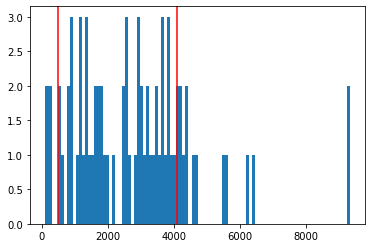

In [8]:
# print the length of all the tokenized documents as a histogram
data = [len(x["input_ids"][0]) for x in tokenized_long_dataset['train']]
plot = plt.pyplot.hist(data, bins=100)

# plot vertical line at 512
plt.pyplot.axvline(x=512, color='r', linestyle='-')
plt.pyplot.axvline(x=4096, color='r', linestyle='-')

print(f"Average length: {np.mean(data)}")
print(f"Median length: {np.median(data)}")
print(f"Max length: {np.max(data)}")
print(f"Min length: {np.min(data)}")

In [9]:
short_documents = [x for x in tokenized_long_dataset['train'] if len(x["input_ids"][0]) <= 512]
print(f"Number of documents with less than 512 tokens: {len(short_documents)}")
for doc in short_documents:
    print(f"Document length: {len(doc['input_ids'][0])}")
    print(doc['paragraphs'][0]['context'])


Number of documents with less than 512 tokens: 4
Document length: 141
Privacy Statement We allow third-party companies to serve ads and/or collect certain anonymous information when you visit our web site. These companies may use non-personally identifiable information (e.g., click stream information, browser type, time and date, subject of advertisements clicked or scrolled over) during your visits to this and other Web sites in order to provide advertisements about goods and services likely to be of greater interest to you. These companies typically use a cookie or third party web beacon to collect this information. To learn more about this behavioral advertising practice or to opt-out of this type of advertising, you can visit networkadvertising.org.
Document length: 294
Google Adsense and the DoubleClick DART Cookie Google, as a third party advertisement vendor, uses cookies to serve ads on this site. The use of DART cookies by Google enables them to serve adverts to visitors that 

In [12]:
ckpt = "mrm8488/longformer-base-4096-finetuned-squadv2"
tokenizer = transformers.AutoTokenizer.from_pretrained(ckpt)
model = transformers.AutoModelForQuestionAnswering.from_pretrained(ckpt)

qa = transformers.pipeline("question-answering", model=model, tokenizer=tokenizer)

text = "Huggingface has democratized NLP. Huge thanks to Huggingface for this."
question = "What has Huggingface done?"

qa({"question": question, "context": text})


{'score': 0.9720897078514099,
 'start': 16,
 'end': 32,
 'answer': 'democratized NLP'}

In [22]:
data = datasets.load_dataset('squad', split='validation')
squad_metric = evaluate.load("squad")
task_evaluator = evaluate.evaluator("question-answering")
eval_results = task_evaluator.compute(
    model_or_pipeline=qa,
    data=data
)
eval_results

Reusing dataset squad (/home/liam/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
100%|██████████| 11/11 [00:00<00:00, 42.89ba/s]
`squad_v2_format` parameter not provided to QuestionAnsweringEvaluator.compute(). Automatically inferred `squad_v2_format` as False.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 